In [1]:
# imports
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import constants
from solarprophet import TabularTest
import utils

In [2]:
model_name = "SOL-210_CV1"
model = tf.keras.models.load_model(os.path.join(".", "results", model_name))

In [3]:
data_df = utils.load_joint_data(constants.JOINT_DATA_H5_PATH)

Loading .h5 dataset


In [4]:
tt = TabularTest(
    # Required Parameters
    n_steps_in=1,
    n_steps_out=12,
    selected_features=[
        "BRBG Total Cloud Cover [%]",
        "CSI GHI",
        "dni t-4",
        "940nm POM-01 Photometer [uA]",
        "cs_dev_mean t-10 dni",
        "675nm POM-01 Photometer [uA]",
        "CSI DNI",
        "elevation",
        "cs_dev t dni",
        "dni t-9",
    ],
    selected_groups=None,
    selected_responses=["Delta CSI GHI"],
    scaler_type="minmax",
    data_path=constants.JOINT_DATA_H5_PATH,
    ## Saving and cache parameters (optional)
    model_save_path="results",
    datetimes_cache_path=constants.DATETIME_VALUES_PATH,
    window_cache_path=os.path.join("data", "windows_cache.h5"),
    all_past_features=constants.PAST_FEATURES,
    all_future_features=constants.FUTURE_FEATURES,
    all_scalar_responses=constants.SCALAR_RESPONSES,
    all_relative_responses=constants.RELATIVE_RESPONSES,
    # Model (optional)
    model=None,
    model_name="TimeDistributed_CNN-LSTM-MLP",
    # Optimizer and training tuning parameters (optional)
    scale_responses=True,
    epochs=3000,
    shuffle_training_order=False,
    batch_size=4000,
    loss="mae",
    optimizer=None,
    learning_rate=tf.optimizers.schedules.CosineDecayRestarts(
        1e-2,  # initial learning rate
        500,  # number of steps to initially decay over
        t_mul=4,  # number of times to restart
        m_mul=0.5,  # restart maximum learning rate multiplier
        alpha=0,
    ),
    callbacks=[],
    early_stopping=True,
    stopping_patience=1000,
    stopping_min_delta=1e-4,
    metrics=[],  # todo possibly replace
    fit_verbose=1,
    # Utility Parameters (optional)
    data_cols=constants.DATA_COLS,
    feature_groups=constants.FEATURE_GROUPS,
    scalar_response=constants.SCALAR_RESPONSES,
    relative_response=constants.RELATIVE_RESPONSES,
    seed=42,
    n_job_workers=1,
    # Neptune Parameters (optional)
    neptune_log=False,
    neptune_run_name="",
    tags=[],
)
tt.import_preprocess_cached_windows("2021-09-27", "2022-09-27", True)

====== Reading windows from cache ======
past_features.shape: (78930, 1, 134)

Done
Relative Response
Train windows: 65727

self.train_dates.shape=(65727, 13)

self.train_past_features.shape=(65727, 1, 10)

self.train_future_features.shape=(65727, 12, 0)

self.train_scalar_responses.shape=(65727, 12, 0)

self.train_relative_responses.shape=(65727, 12, 1)

self.train_clear_sky_indexes.shape=(65727, 13)

self.train_clear_sky_irradiances.shape=(65727, 13)
Validate windows: 13147


<Axes: ylabel='Density'>

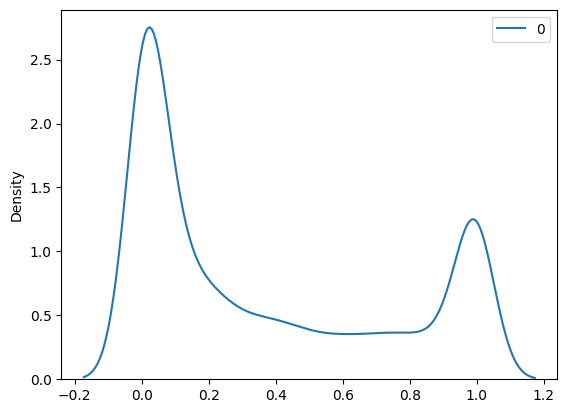

In [5]:
sns.kdeplot(tt.validate_past_features[:, :, 0])

In [6]:
rows = tt.validate_past_features[:, :, 0].flatten() < 0.2
x = tt.validate_past_features[rows]
y = model.predict(x)
y = tt.rescale_to_GHI(
    y,
    tt.validate_clear_sky_irradiances[rows],
    tt.validate_clear_sky_indexes[rows],
)
Y = tt.y_validate_true[rows]
Y = tt.rescale_to_GHI(
    Y,
    tt.validate_clear_sky_irradiances[rows],
    tt.validate_clear_sky_indexes[rows],
)
clear_mae = utils.MAE(Y, y, axis=1)

rows = tt.validate_past_features[:, :, 0].flatten() > 0.8
x = tt.validate_past_features[rows]
y = model.predict(x)
y = tt.rescale_to_GHI(
    y,
    tt.validate_clear_sky_irradiances[rows],
    tt.validate_clear_sky_indexes[rows],
)
Y = tt.y_validate_true[rows]
Y = tt.rescale_to_GHI(
    Y,
    tt.validate_clear_sky_irradiances[rows],
    tt.validate_clear_sky_indexes[rows],
)
overcast_mae = utils.MAE(Y, y, axis=1)

rows = (tt.validate_past_features[:, :, 0].flatten() < 0.8) & (
    tt.validate_past_features[:, :, 0].flatten() > 0.2
)
x = tt.validate_past_features[rows]
y = model.predict(x)
y = tt.rescale_to_GHI(
    y,
    tt.validate_clear_sky_irradiances[rows],
    tt.validate_clear_sky_indexes[rows],
)
Y = tt.y_validate_true[rows]
Y = tt.rescale_to_GHI(
    Y,
    tt.validate_clear_sky_irradiances[rows],
    tt.validate_clear_sky_indexes[rows],
)
partial_mae = utils.MAE(Y, y, axis=1)

2024-02-08 09:58:28.171317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-08 09:58:28.401780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/93 [===>..........................] - ETA: 0s 

2024-02-08 09:58:30.162403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-08 09:58:30.221417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


106/106 [==============================] - 1s 5ms/step


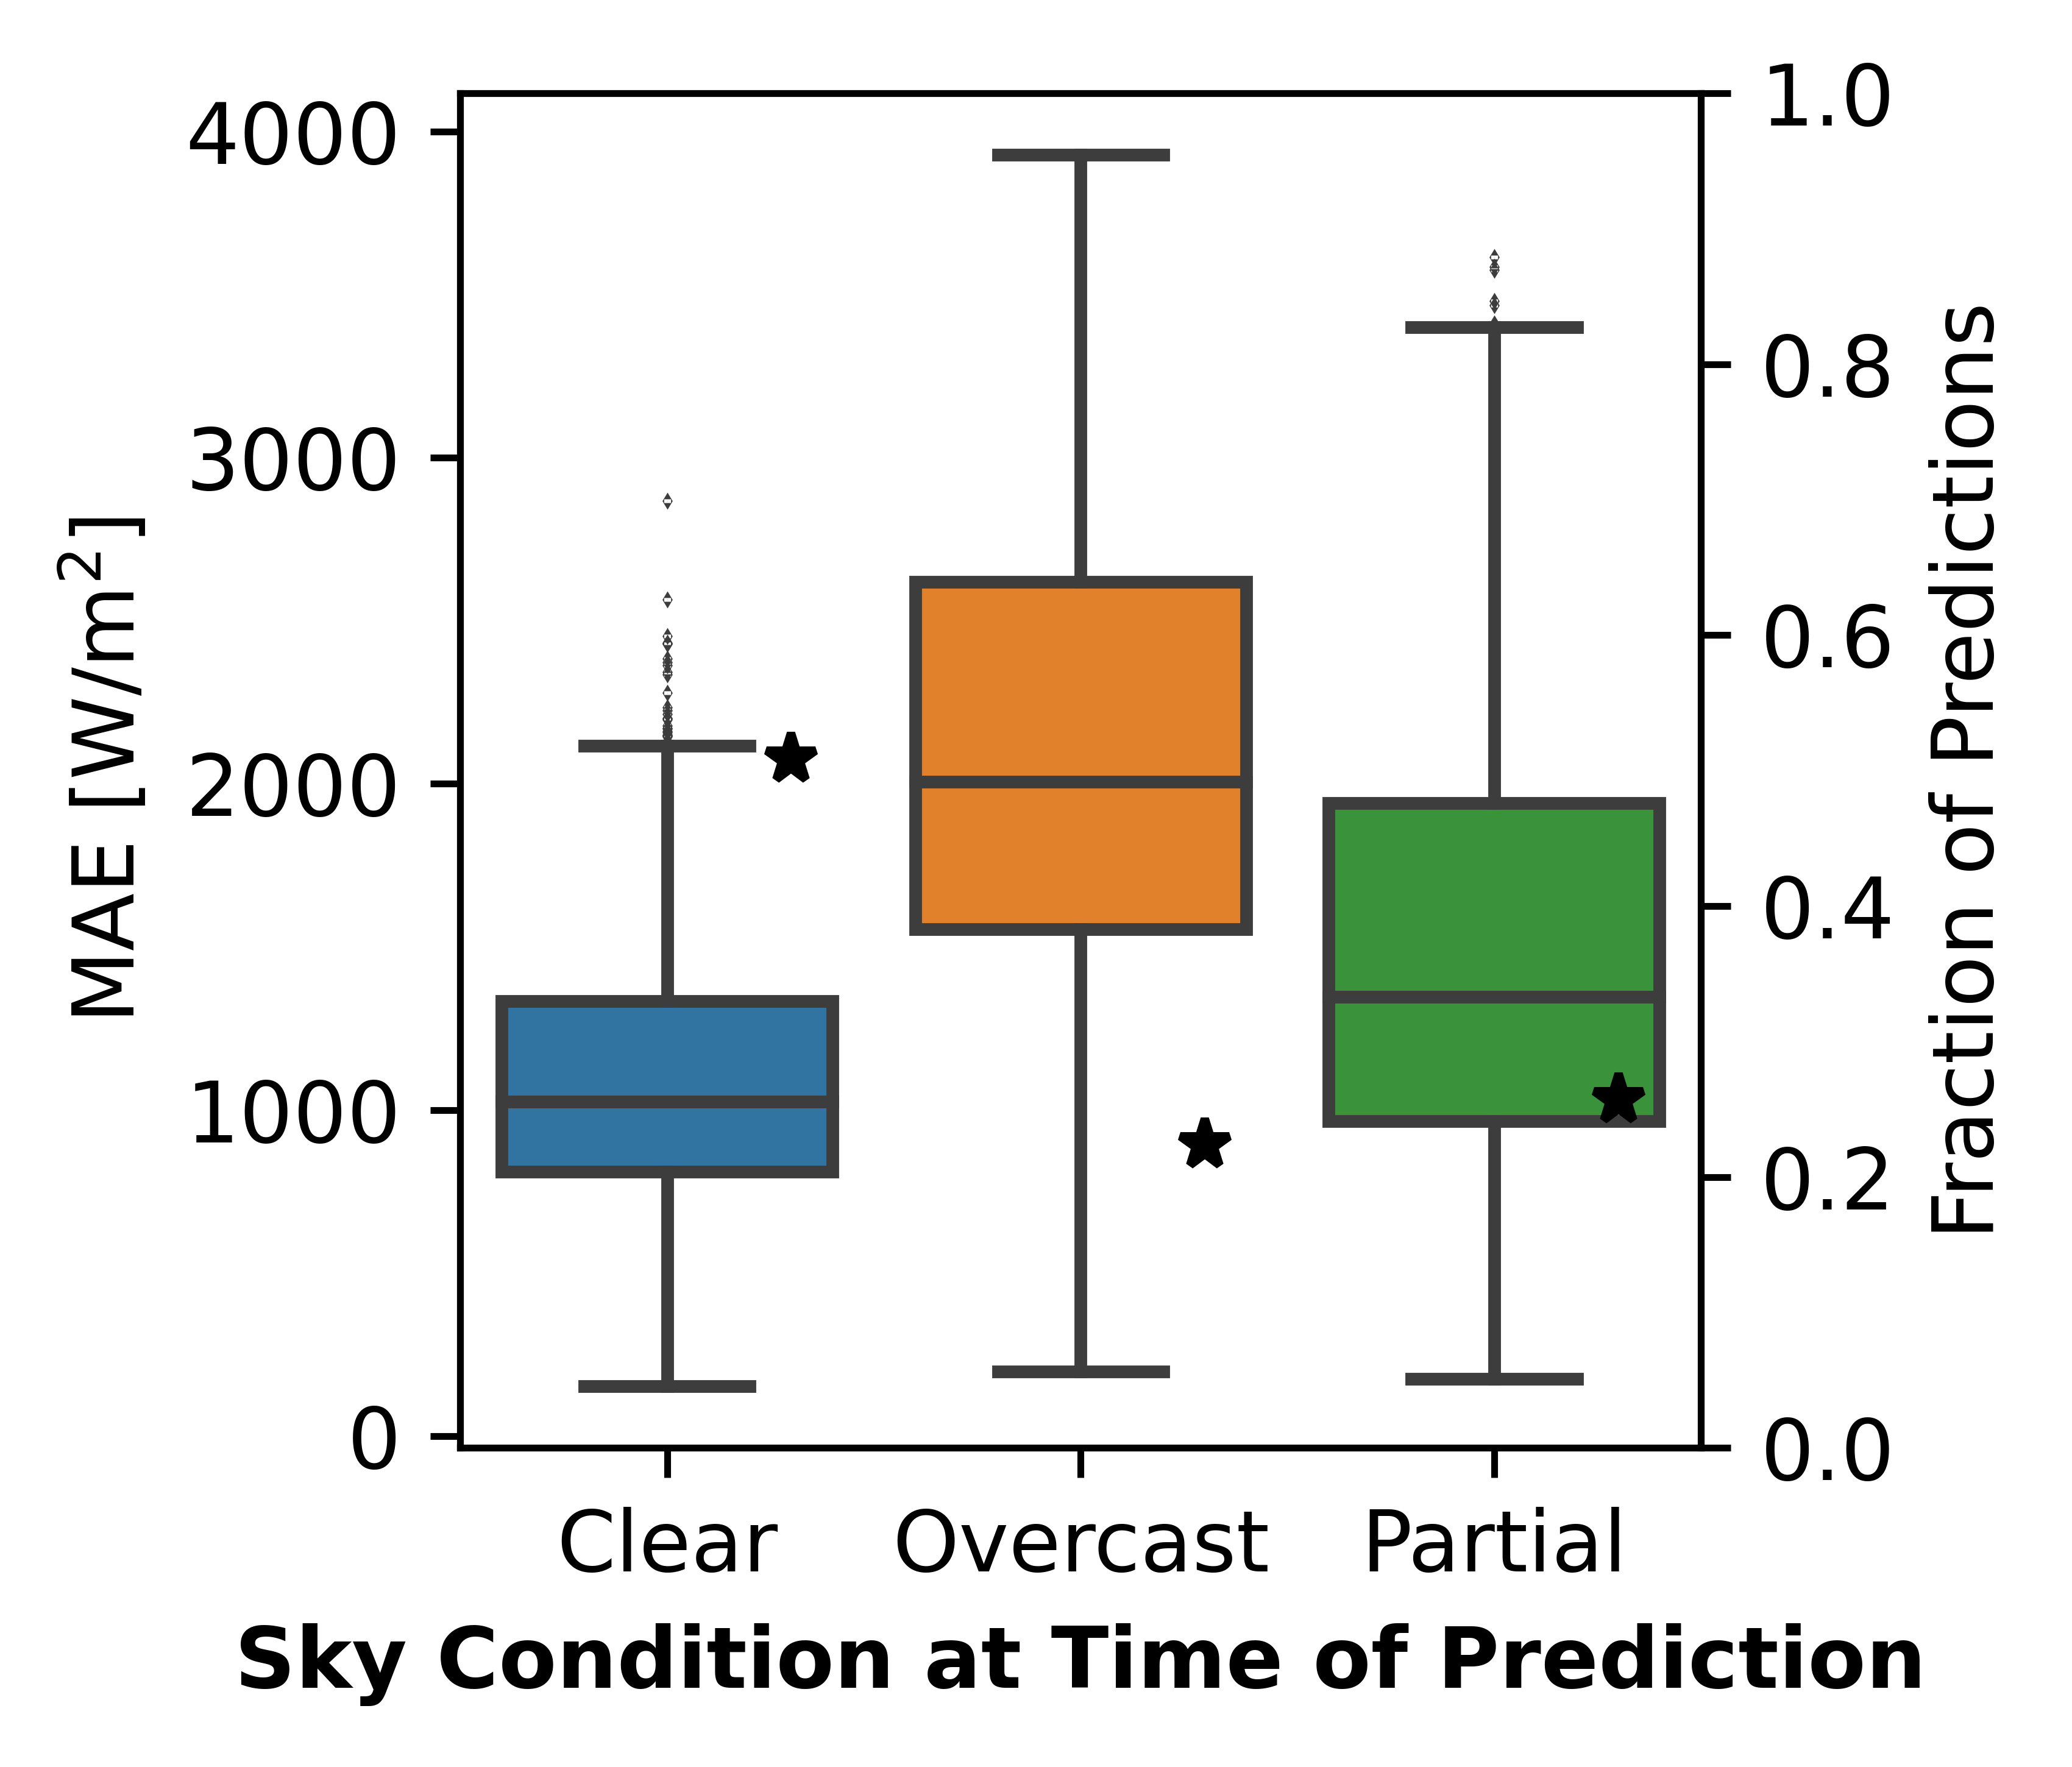

In [7]:
df = pd.DataFrame()
df["Clear"] = pd.Series(clear_mae)
df["Overcast"] = pd.Series(overcast_mae)
df["Partial"] = pd.Series(partial_mae)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3), sharex=True, dpi=1000)
sns.boxplot(df, fliersize=0.05, ax=ax)
ax.set_ylabel("MAE [W/m$^2$]")  # , fontdict={"fontweight": "bold"})
ax.set_xlabel("Sky Condition at Time of Prediction", fontdict={"fontweight": "bold"})
lclear = len(clear_mae) / tt.validate_past_features.shape[0]
lovercast = len(overcast_mae) / tt.validate_past_features.shape[0]
lpartial = len(partial_mae) / tt.validate_past_features.shape[0]
ax2 = ax.twinx()
ax2.plot(
    [0.3, 1.3, 2.3],
    [lclear, lovercast, lpartial],
    color="black",
    marker="*",
    linestyle="None",
)
ax2.set_ylim([0, 1])
ax2.set_ylabel("Fraction of Predictions")  # , fontdict={"fontweight": "bold"})

fig.tight_layout()
fig.savefig(os.path.join(".", "Reports", "Images", "sky_condition_boxplot.pdf"))

In [9]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))


tt = TabularTest(
    # Required Parameters
    n_steps_in=1,
    n_steps_out=12,
    selected_features=[
        "BRBG Total Cloud Cover [%]",
        "CSI GHI",
        "dni t-4",
        "940nm POM-01 Photometer [uA]",
        "cs_dev_mean t-10 dni",
        "675nm POM-01 Photometer [uA]",
        "CSI DNI",
        "elevation",
        "cs_dev t dni",
        "dni t-9",
    ],
    selected_groups=None,
    selected_responses=["Delta CSI GHI"],
    scaler_type="minmax",
    data_path=constants.JOINT_DATA_H5_PATH,
    ## Saving and cache parameters (optional)
    model_save_path="results",
    datetimes_cache_path=constants.DATETIME_VALUES_PATH,
    window_cache_path=os.path.join("data", "windows_cache.h5"),
    all_past_features=constants.PAST_FEATURES,
    all_future_features=constants.FUTURE_FEATURES,
    all_scalar_responses=constants.SCALAR_RESPONSES,
    all_relative_responses=constants.RELATIVE_RESPONSES,
    # Model (optional)
    model=None,
    model_name="TimeDistributed_CNN-LSTM-MLP",
    # Optimizer and training tuning parameters (optional)
    scale_responses=True,
    epochs=3000,
    shuffle_training_order=False,
    batch_size=4000,
    loss=rmse,
    optimizer=None,
    learning_rate=tf.optimizers.schedules.CosineDecayRestarts(
        1e-2,  # initial learning rate
        500,  # number of steps to initially decay over
        t_mul=4,  # number of times to restart
        m_mul=0.5,  # restart maximum learning rate multiplier
        alpha=0,
    ),  # this should be static or a tf.optimizers.schedules object
    callbacks=[],
    early_stopping=True,
    stopping_patience=1000,
    stopping_min_delta=1e-4,
    metrics=[],  # todo possibly replace
    fit_verbose=1,
    # Utility Parameters (optional)
    data_cols=constants.DATA_COLS,
    feature_groups=constants.FEATURE_GROUPS,
    scalar_response=constants.SCALAR_RESPONSES,
    relative_response=constants.RELATIVE_RESPONSES,
    seed=42,
    n_job_workers=1,
    # Neptune Parameters (optional)
    neptune_log=True,
    neptune_run_name=f"Fine Tuning Feature number",
    tags=["CV2", "Time Steps"],
)

original_epochs = tt.epochs

train_validate_dates = ["2021-09-27"]
end_dates = ["2022-09-27"]
for i in range(len(train_validate_dates)):
    print(f" Starting Fine Tuning ".center(40, "="))
    tt.import_preprocess_cached_windows(
        train_validate_date=train_validate_dates[i], end_date=end_dates[i], verbose=2
    )

    # compile the model to fit for 500 epochs with mse then mae

    remaining_epochs = max(500, original_epochs - 500)
    tt.loss = rmse
    tt.epochs = 500
    tt.compile_model()
    tt.fit_model()

    # extract the weights and recompile with new loss function
    weights = tt.model.get_weights()
    tt.loss = rmse
    tt.epochs = remaining_epochs
    tt.compile_model()
    tt.fit_model()

    print(" Fit Complete ".center(40, "-"))
    print(" Calculating Error Metrics ".center(40, "-"))
    tt.final_error_metrics(cv=i + 1)
    print(" Error Metrics Complete ".center(40, "-"))
    print(" Saving ".center(40, "-"))
    tt.save_and_quit(cv=i + 1)
    print(" Saved ".center(40, "-"))
    print(" Complete! ".center(40, "="))

https://app.neptune.ai/HorizonPSE/SolarProphet-II/e/SOL-232
========= Starting Fine Tuning =========
====== Reading windows from cache ======
past_features.shape: (78930, 1, 134)

Done
 Selecting and scaling relevant features and responses 
datetimes.shape: (78930, 13)
past_features.shape: (78930, 1, 134)
future_features.shape: (78930, 12, 7)
scalar_responses.shape: (78930, 12, 3)
relative_responses.shape: (78930, 12, 2)
clear_sky_indexes.shape: (78930, 13)
clear_sky_irradiances.shape: (78930, 13)


c:\Users\jhamm\anaconda3\envs\solarprophet\lib\site-packages\neptune\common\warnings.py:62: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'function'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  warnings.warn(


# selected past features: 10
# selected future features: 0
# selected scalar responses: 0
# selected relative responses: 1
selected_past_features_indices=[3, 17, 96, 80, 114, 78, 18, 71, 15, 111]
selected_future_features_indices=[]
selected_scalar_responses_indices=[]
selected_relative_responses_indices=[1]
train_dates.shape: (65727, 13)
train_past_features.shape: (65727, 1, 10)
train_future_features.shape: (65727, 12, 0)
train_scalar_responses.shape: (65727, 12, 0)
train_relative_responses.shape: (65727, 12, 1)
train_clear_sky_indexes.shape: (65727, 13)
train_clear_sky_irradiances.shape: (65727, 13)
validate_dates.shape: (13147, 13)
validate_past_features.shape: (13147, 1, 10)
validate_future_features.shape: (13147, 12, 0)
validate_scalar_responses.shape: (13147, 12, 0)
validate_relative_responses.shape: (13147, 12, 1)
validate_clear_sky_indexes.shape: (13147, 13)
validate_clear_sky_irradiances.shape: (13147, 13)
Relative Response
Train windows: 65727

self.train_dates.shape=(65727, 1

INFO:tensorflow:Assets written to: results\SOL-232_CV1\assets


INFO:tensorflow:Assets written to: results\SOL-232_CV1\assets


---------------- Saved -----------------
============== Complete! ===============
